In [39]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from py_utils import collection_utils

2017-01-24 11:05:35,533:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly
2017-01-24 11:05:35,533:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [54]:
training_type = 'multi_source'
versions = rx_train.get_training_result_versions(training_type)
d = {v:rx_train.get_training_results(training_type, v) for v in versions}

2017-01-24 12:35:27,411:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v1/results.pkl"
2017-01-24 12:35:27,411:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v1/results.pkl"
2017-01-24 12:35:29,688:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v2/results.pkl"
2017-01-24 12:35:29,688:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v2/results.pkl"
2017-01-24 12:35:31,935:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v3/results.pkl"
2017-01-24 12:35:31,935:DEBUG:py_utils.io_utils: Restoring s

In [57]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [58]:
import pdb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def _get_scores(d_pred):
    # Greater should always be better
    score_functions = {
        'r2': r2_score,
        'corr': lambda y_true, y_pred: y_pred.corr(y_true),
        'mse': lambda y_true, y_pred: -mean_squared_error(y_true, y_pred),
        'mae': lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred)
    }
    return rx_train.get_scores(d_pred, score_functions)
    
def get_scores():
    d_score = []
    site = 'BREAST'
    for v in d:
        d_pred = d[v]['res'][site]['prediction_data']
        d_score.append(_get_scores(d_pred).assign(VERSION=v))
    return pd.concat(d_score)

d_score = get_scores()

In [59]:
d_score.head()

,DRUG_NAME,MODEL_NAME,FOLD_ID,METRIC,VALUE,VERSION
0,AG014699,meta_lasso,1,corr,6.444394e-01,v1
1,AG014699,meta_lasso,2,corr,-1.269186e-15,v1
2,AG014699,meta_lasso,3,corr,1.748781e-01,v1
3,AG014699,meta_lasso,4,corr,9.992845e-02,v1
4,AG014699,meta_lasso,5,corr,-2.732357e-01,v1


In [60]:
d_score_mean = d_score.groupby(['DRUG_NAME', 'VERSION', 'MODEL_NAME', 'METRIC'])['VALUE'].mean().reset_index()
d_score_mean['VERSION'] = d_score_mean['VERSION'].str.replace('v', '').astype(np.int64)
#d_score.groupby(['DRUG_NAME', 'VERSION']).apply(lambda g: g.sort_values('VALUE', ascending=False).head(1))

In [61]:
d_score_mean.head()

,DRUG_NAME,VERSION,MODEL_NAME,METRIC,VALUE
0,AG014699,1,meta_lasso,corr,0.129202
1,AG014699,1,meta_lasso,mae,-0.847076
2,AG014699,1,meta_lasso,mse,-1.145242
3,AG014699,1,meta_lasso,r2,-1.525300
4,AG014699,1,meta_rf,corr,0.105693


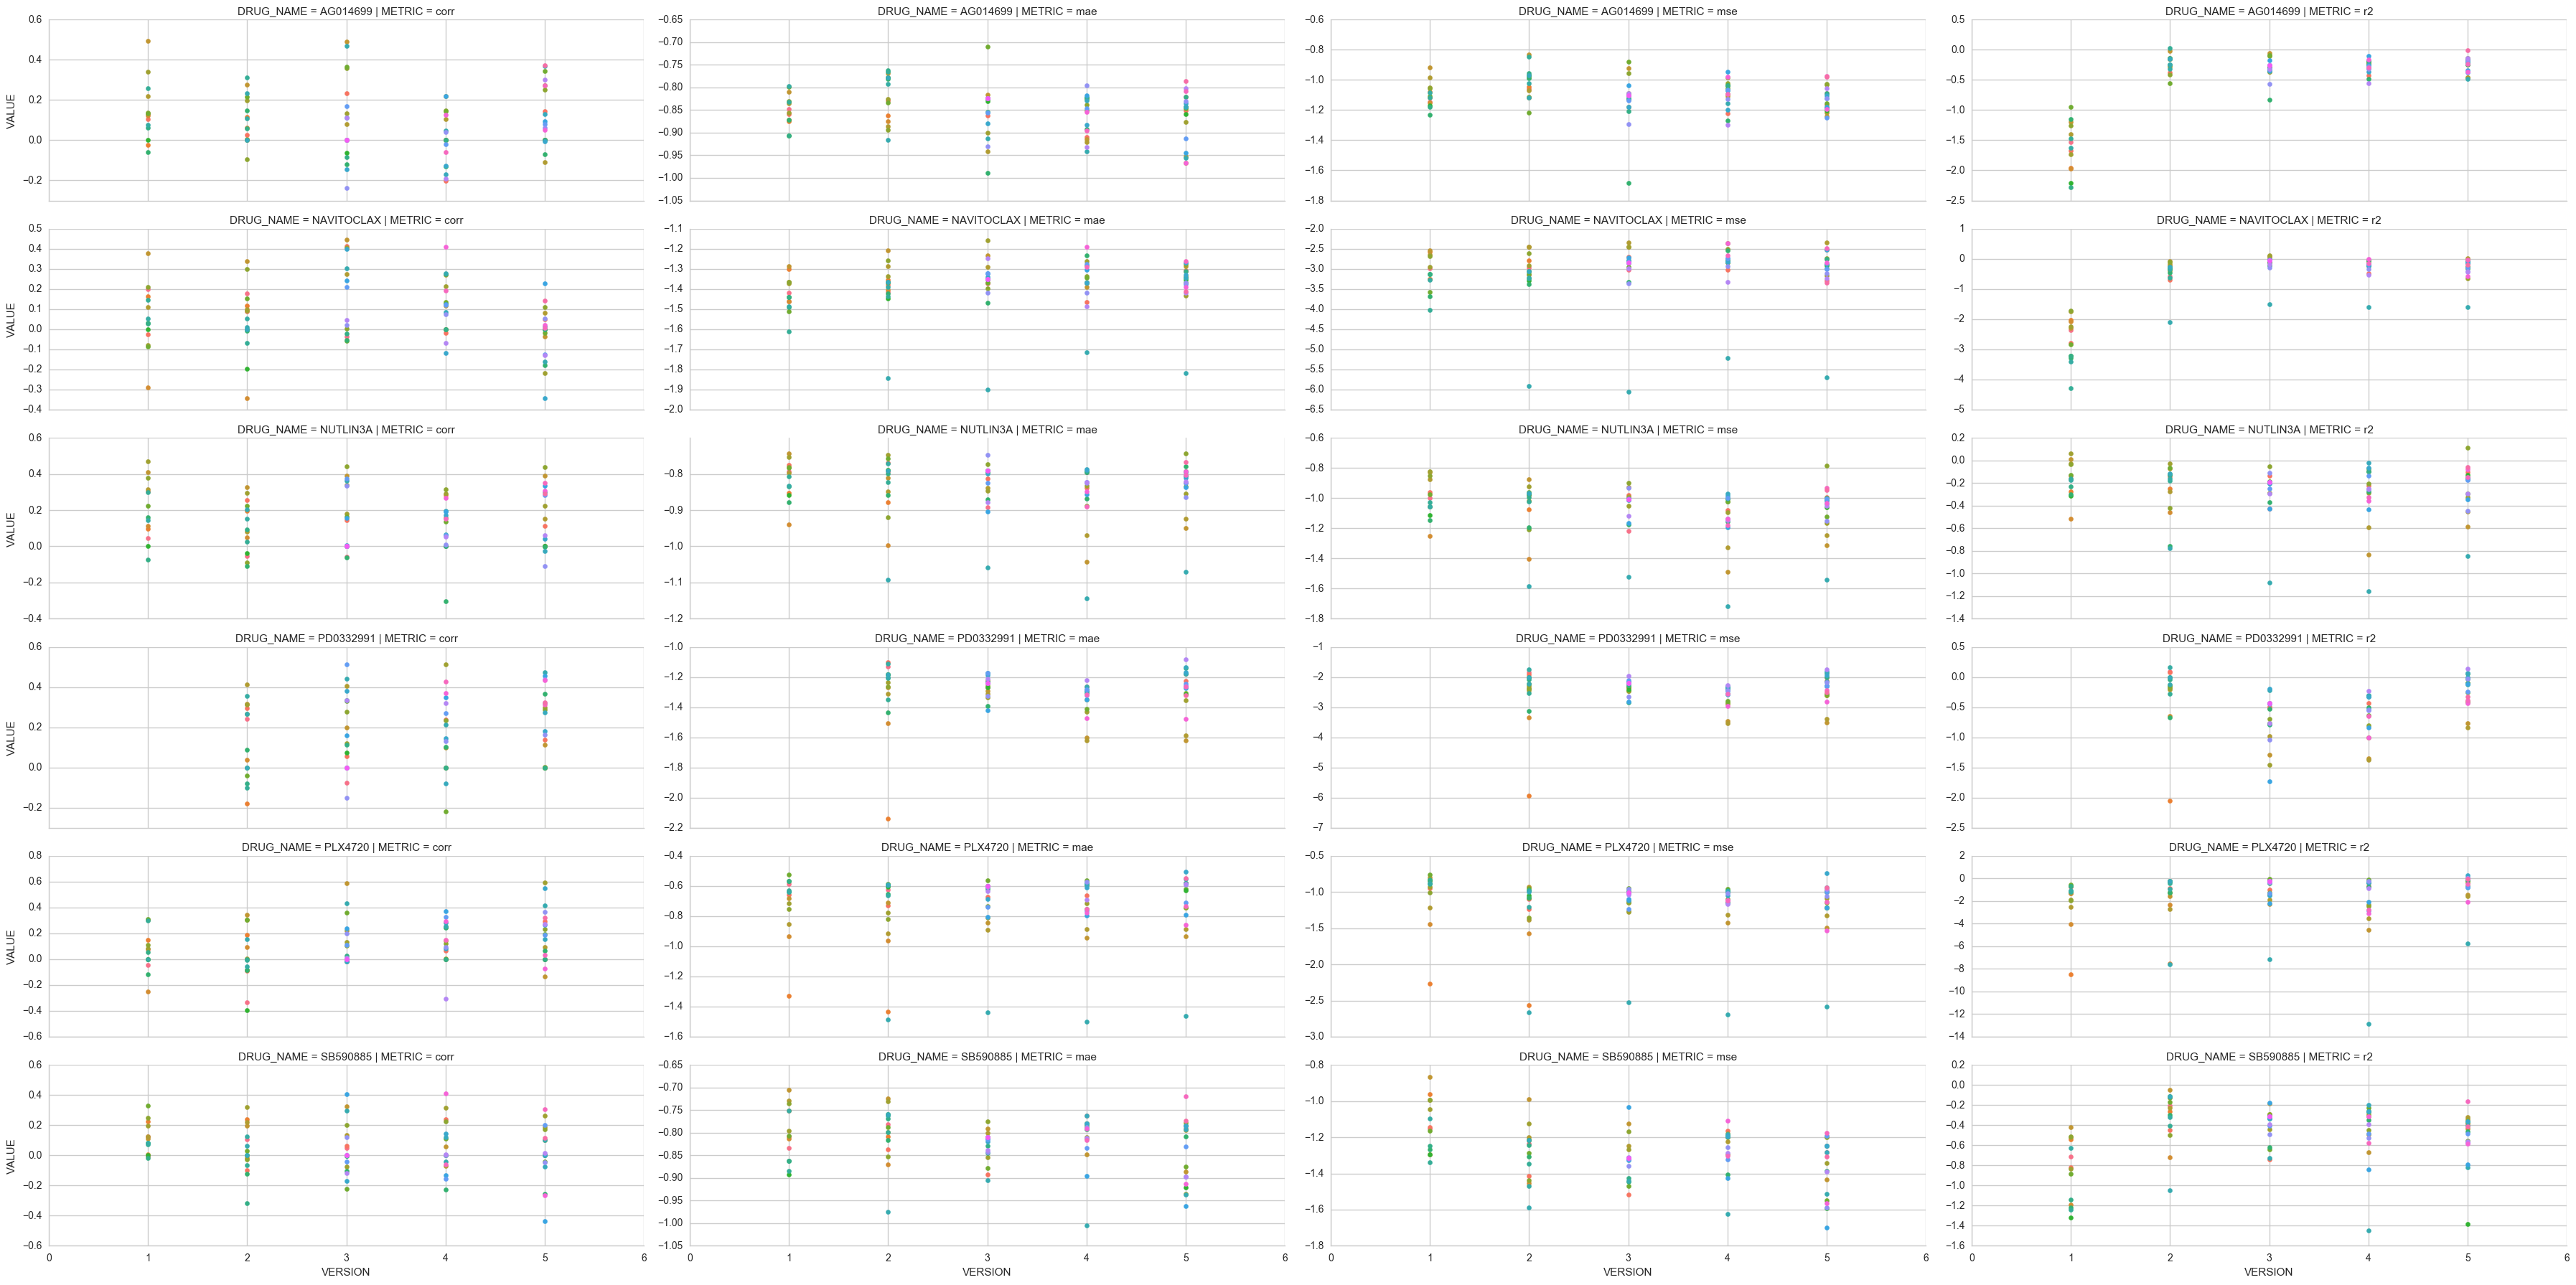

In [62]:
g = sns.FacetGrid(d_score_mean, row='DRUG_NAME', col='METRIC', hue='MODEL_NAME', sharey=False, aspect=3)
g.map(plt.scatter, 'VERSION', 'VALUE')

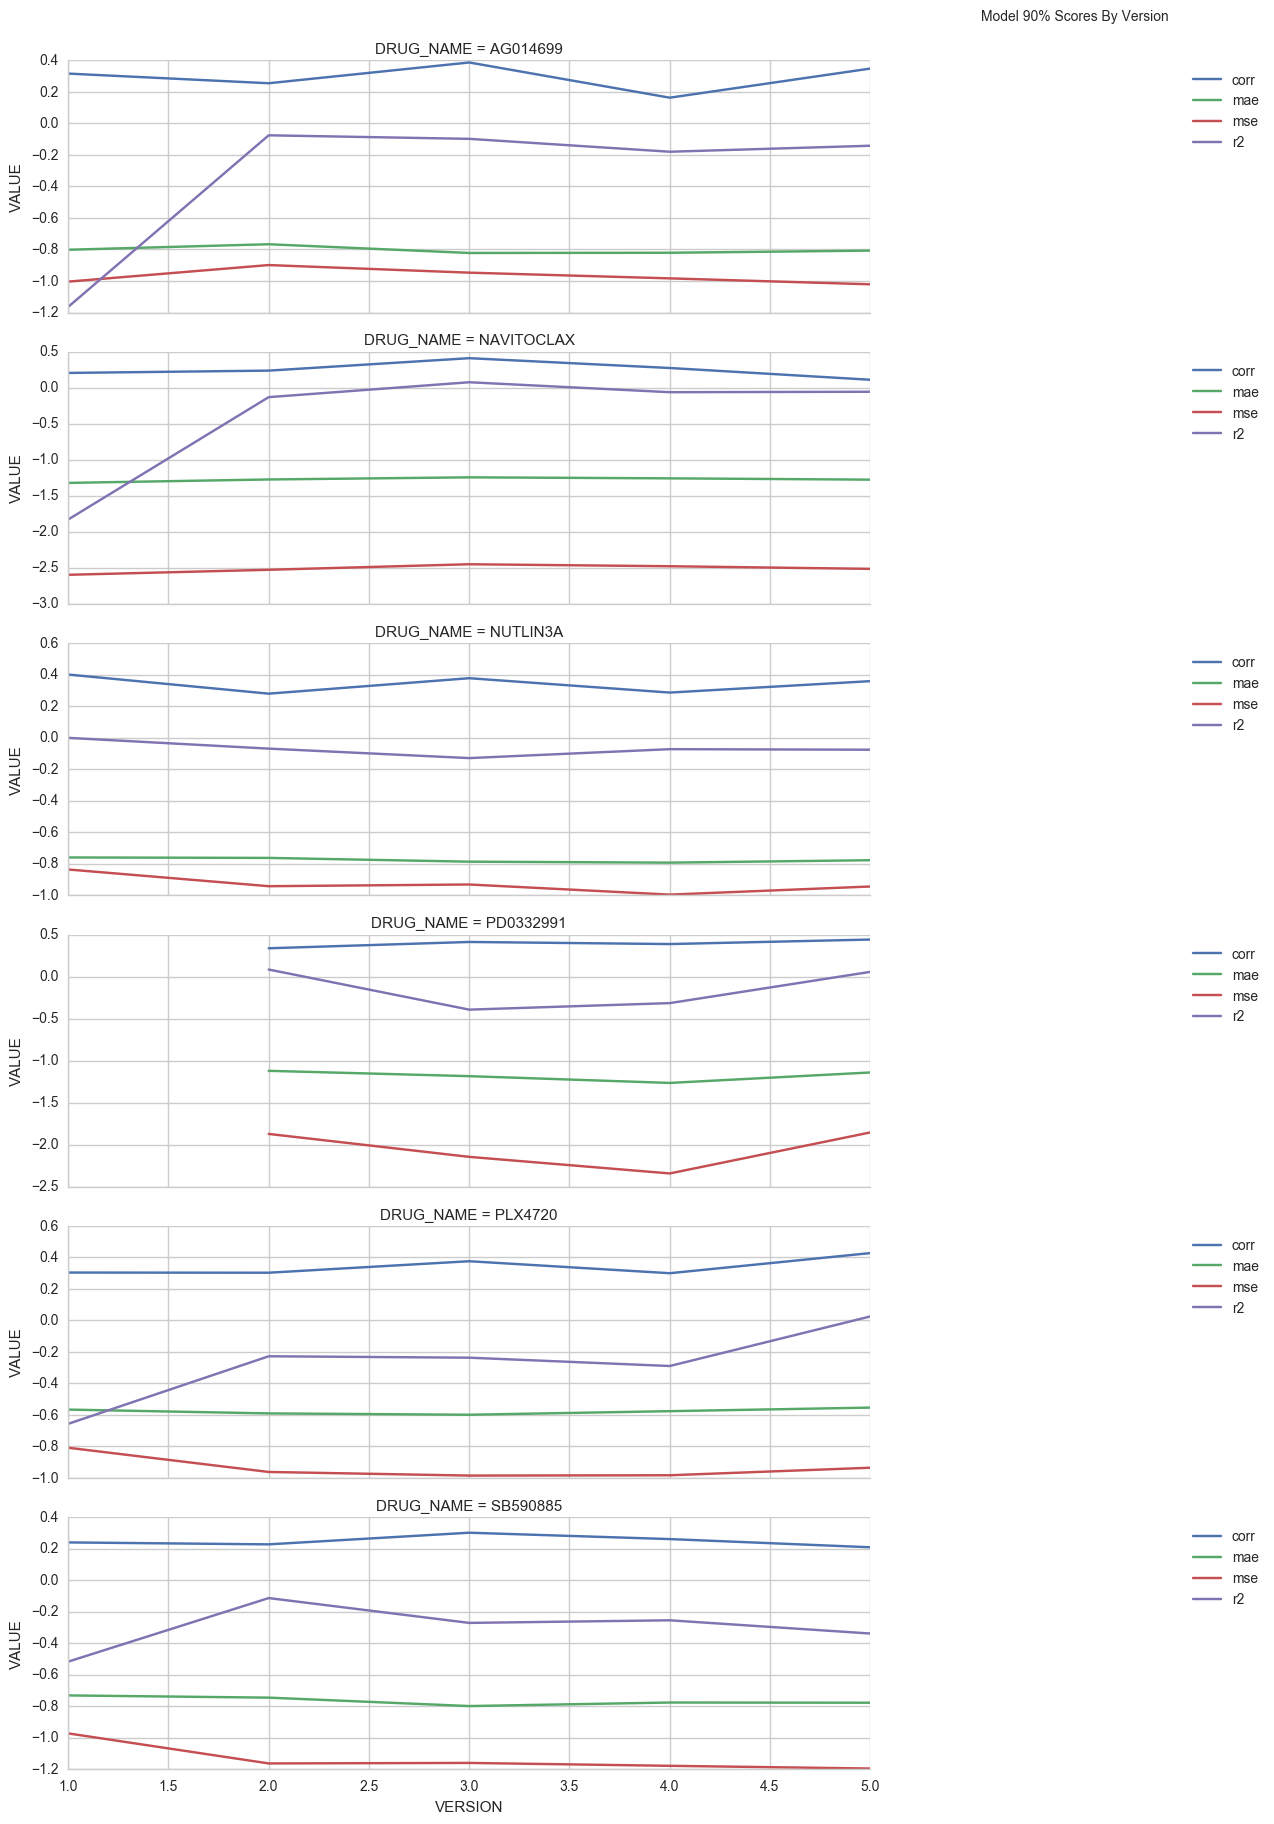

In [66]:
g = sns.FacetGrid(
    d_score_mean.groupby(['DRUG_NAME', 'VERSION', 'METRIC'])['VALUE'].quantile(.9).reset_index(),
    row='DRUG_NAME', hue='METRIC', sharey=False, size=3, aspect=3
)
g.map(plt.plot, 'VERSION', 'VALUE')
[ax.legend(bbox_to_anchor=(1.5, 1)) for ax in g.axes.ravel()]
g.fig.suptitle('Model 90% Scores By Version', x=1.2, y=1.01)
print()